### Binary Classification Model for Bondora P2P Lending Using Python and Scikit-Learn
### David Lowe
### August 31, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Bondora P2P Lending dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: The Kaggle dataset owner retrieved this dataset from Bondora, a leading European peer-to-peer lending platform. The data comprises demographic and financial information of the borrowers with defaulted and non-defaulted loans between February 2009 and July 2021. For investors, “peer-to-peer lending” or “P2P” offers an attractive way to diversify portfolios and enhance long-term performance. However, to make effective decisions, investors want to minimize the risk of default of each lending decision and realize the return that compensates for the risk. Therefore, we will predict the default risk by focusing on the “DefaultDate” attribute as the target.

ANALYSIS: The average performance of the machine learning algorithms achieved a ROC-AUC benchmark of 0.9539 using the training dataset. We selected Random Forest and Extra Trees to perform the tuning exercises. After a series of tuning trials, the refined Extra Trees model processed the training dataset with a final ROC-AUC score of 0.9801. When we processed the test dataset with the final model, the model achieved a ROC-AUC score of 0.9162.

CONCLUSION: In this iteration, the Random Forest model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Bondora P2P Lending Loan Data

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/sid321axn/bondora-peer-to-peer-lending-loan-data

Dataset Attribute Description: https://www.bondora.com/en/public-reports

One potential source of performance benchmark: https://www.kaggle.com/sid321axn/bondora-peer-to-peer-lending-loan-data/code

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 8

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline as SKL_Pipeline
from sklearn import compose
from sklearn import impute
from imblearn.pipeline import Pipeline as IMB_Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 2

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
# VAL_SET_RATIO = 0.2
TEST_SET_RATIO = 0.1

# Set the number of folds for cross validation
N_FOLDS = 10

# Set various default modeling parameters
SCORING_METRIC = 'roc_auc'

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [10]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-bondora-p2p-lending/LoanData_Bondora.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

/home/pythonml/appdev/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (34,38,80,82,83,89,90) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


  ReportAsOfEOD                                LoanId  LoanNumber  \
0    2021-07-20  66AE108B-532B-4BB3-BAB7-0019A46412C1      483449   
1    2021-07-20  D152382E-A50D-46ED-8FF2-0053E0C86A70      378148   
2    2021-07-20  87342E13-66CB-483F-833A-007953E50C78      451831   
3    2021-07-20  87227056-6BF9-410C-98D1-008F788E122A      349381   
4    2021-07-20  2DDE6336-E466-4624-A337-00A0ED1A1468      443082   

           ListedOnUTC     BiddingStartedOn  BidsPortfolioManager  BidsApi  \
0  2016-03-23 16:07:19  2016-03-23 16:07:19                   970     1150   
1  2015-06-25 11:02:28  2015-06-25 11:02:28                  1295        0   
2  2016-01-14 10:00:21  2016-01-14 10:00:21                  2700      565   
3  2015-03-24 15:55:44  2015-03-24 15:55:44                  1115        0   
4  2015-12-17 10:12:00  2015-12-17 10:12:00                   305        0   

   BidsManual   UserName  NewCreditCustomer  ...  \
0         5.0   BO965519              False  ...   
1      1705.

In [11]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179235 entries, 0 to 179234
Data columns (total 112 columns):
 #    Column                                  Dtype  
---   ------                                  -----  
 0    ReportAsOfEOD                           object 
 1    LoanId                                  object 
 2    LoanNumber                              int64  
 3    ListedOnUTC                             object 
 4    BiddingStartedOn                        object 
 5    BidsPortfolioManager                    int64  
 6    BidsApi                                 int64  
 7    BidsManual                              float64
 8    UserName                                object 
 9    NewCreditCustomer                       bool   
 10   LoanApplicationStartedDate              object 
 11   LoanDate                                object 
 12   ContractEndDate                         object 
 13   FirstPaymentDate                        object 
 14   MaturityDate_Origi

In [12]:
print(df_dataset_import.describe())

         LoanNumber  BidsPortfolioManager        BidsApi     BidsManual  \
count  1.792350e+05         179235.000000  179235.000000  179235.000000   
mean   1.239306e+06            797.962530      27.432337     499.544776   
std    6.610266e+05           1235.509764     147.568318     714.723996   
min    3.700000e+01              0.000000       0.000000       0.000000   
25%    7.125380e+05            105.000000       0.000000      50.000000   
50%    1.096557e+06            336.000000       0.000000     258.000000   
75%    1.851458e+06            960.000000       4.000000     639.116700   
max    2.313298e+06          10625.000000    7570.000000   10630.000000   

       ApplicationSignedHour  ApplicationSignedWeekday  VerificationType  \
count          179235.000000             179235.000000     179185.000000   
mean               13.325260                  3.917907          3.043402   
std                 4.995317                  1.752335          1.352504   
min                 

In [13]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

ReportAsOfEOD                               0
LoanId                                      0
LoanNumber                                  0
ListedOnUTC                                 0
BiddingStartedOn                            0
                                        ...  
NrOfScheduledPayments                   66944
ReScheduledOn                          116191
PrincipalDebtServicingCost             103085
InterestAndPenaltyDebtServicingCost    103085
ActiveLateLastPaymentCategory           96967
Length: 112, dtype: int64
Total number of NaN in the dataframe:  5273975


### 1.d) Data Cleaning

In [14]:
# Identify features with too many nulls to be useful
high_pct_null_features = []
total_records = df_dataset_import.shape[0]
for feature in df_dataset_import.columns:
    missing_records = df_dataset_import[feature].isnull().sum()
    missing_percentage = missing_records / total_records
    print('The feature %s has %d missing rows. Percentage: %g%%' % (feature, missing_records, missing_percentage*100))
    if missing_percentage >= 0.75:
        high_pct_null_features.append(feature)
print('Proposed list of features for removal:', high_pct_null_features)

The feature ReportAsOfEOD has 0 missing rows. Percentage: 0%
The feature LoanId has 0 missing rows. Percentage: 0%
The feature LoanNumber has 0 missing rows. Percentage: 0%
The feature ListedOnUTC has 0 missing rows. Percentage: 0%
The feature BiddingStartedOn has 0 missing rows. Percentage: 0%
The feature BidsPortfolioManager has 0 missing rows. Percentage: 0%
The feature BidsApi has 0 missing rows. Percentage: 0%
The feature BidsManual has 0 missing rows. Percentage: 0%
The feature UserName has 0 missing rows. Percentage: 0%
The feature NewCreditCustomer has 0 missing rows. Percentage: 0%
The feature LoanApplicationStartedDate has 0 missing rows. Percentage: 0%
The feature LoanDate has 0 missing rows. Percentage: 0%
The feature ContractEndDate has 76239 missing rows. Percentage: 42.5358%
The feature FirstPaymentDate has 0 missing rows. Percentage: 0%
The feature MaturityDate_Original has 0 missing rows. Percentage: 0%
The feature MaturityDate_Last has 0 missing rows. Percentage: 0%
T

In [15]:
# Identify more non-essential features to remove
non_essential_features = ['ReportAsOfEOD','LoanId','LoanNumber','ListedOnUTC','BiddingStartedOn',
                          'BidsPortfolioManager','BidsApi','BidsManual','UserName','LoanApplicationStartedDate',
                          'LoanDate','ContractEndDate','FirstPaymentDate','MaturityDate_Original','MaturityDate_Last',
                          'ApplicationSignedHour','ApplicationSignedWeekday','LanguageCode','Country',
                          'UseOfLoan','MaritalStatus','EmploymentStatus','OccupationArea','MonthlyPaymentDay',
                          'ActiveScheduleFirstPaymentReached','PlannedPrincipalTillDate','PlannedInterestTillDate','LastPaymentOn',
                          'DebtOccuredOn','DebtOccuredOnForSecondary','ModelVersion','EL_V0','Rating_V0',
                          'EL_V1','Rating_V1','Rating_V2','CreditScoreEsMicroL','CreditScoreEeMini',
                          'PrincipalPaymentsMade','InterestAndPenaltyWriteOffs','PrincipalBalance','InterestAndPenaltyBalance',
                          'NextPaymentDate','NextPaymentNr','NrOfScheduledPayments','ReScheduledOn']

# Identify post-mortem features induced by default
post_mortem_features = ['CurrentDebtDaysPrimary','DebtOccuredOn','CurrentDebtDaysSecondary','DebtOccuredOnForSecondary',
                        'PrincipalOverdueBySchedule','PlannedPrincipalPostDefault','PlannedInterestPostDefault',
                        'EAD1','EAD2','PrincipalRecovery','InterestRecovery','RecoveryStage',
                        'StageActiveSince','ActiveLateCategory','WorseLateCategory','PrincipalWriteOffs',
                        'PrincipalDebtServicingCost','InterestAndPenaltyDebtServicingCost',
                        'InterestAndPenaltyWriteOffs','ActiveLateLastPaymentCategory']

final_features_removal = non_essential_features + high_pct_null_features + post_mortem_features
print('Final list of features to remove:', final_features_removal)

Final list of features to remove: ['ReportAsOfEOD', 'LoanId', 'LoanNumber', 'ListedOnUTC', 'BiddingStartedOn', 'BidsPortfolioManager', 'BidsApi', 'BidsManual', 'UserName', 'LoanApplicationStartedDate', 'LoanDate', 'ContractEndDate', 'FirstPaymentDate', 'MaturityDate_Original', 'MaturityDate_Last', 'ApplicationSignedHour', 'ApplicationSignedWeekday', 'LanguageCode', 'Country', 'UseOfLoan', 'MaritalStatus', 'EmploymentStatus', 'OccupationArea', 'MonthlyPaymentDay', 'ActiveScheduleFirstPaymentReached', 'PlannedPrincipalTillDate', 'PlannedInterestTillDate', 'LastPaymentOn', 'DebtOccuredOn', 'DebtOccuredOnForSecondary', 'ModelVersion', 'EL_V0', 'Rating_V0', 'EL_V1', 'Rating_V1', 'Rating_V2', 'CreditScoreEsMicroL', 'CreditScoreEeMini', 'PrincipalPaymentsMade', 'InterestAndPenaltyWriteOffs', 'PrincipalBalance', 'InterestAndPenaltyBalance', 'NextPaymentDate', 'NextPaymentNr', 'NrOfScheduledPayments', 'ReScheduledOn', 'DateOfBirth', 'County', 'City', 'NrOfDependants', 'EmploymentPosition', 'Wor

In [16]:
# Drop non-essential features
df_dataset_import.drop(columns=final_features_removal, inplace=True)

# Convert columns from one data type to another
df_dataset_import['VerificationType'].fillna(0, inplace=True)
df_dataset_import['VerificationType'] = df_dataset_import['VerificationType'].astype('category')
df_dataset_import['Gender'].fillna(2, inplace=True)
df_dataset_import['Gender'] = df_dataset_import['Gender'].astype('category')
df_dataset_import['Education'].fillna(-1, inplace=True)
df_dataset_import['Education'] = df_dataset_import['Education'].astype('category')
df_dataset_import['EmploymentDurationCurrentEmployer'] = df_dataset_import['EmploymentDurationCurrentEmployer'].astype('category')
df_dataset_import['HomeOwnershipType'].fillna(-1, inplace=True)
df_dataset_import['HomeOwnershipType'] = df_dataset_import['HomeOwnershipType'].astype('category')
df_dataset_import['Rating'] = df_dataset_import['Rating'].astype('category')
df_dataset_import['Status'] = df_dataset_import['Status'].astype('category')

# Convert the DefaultDate feature into the 0/1 target variable
df_dataset_import['DefaultDate'].fillna('UNKNOWN', inplace=True)
def reclass_somecol(target):
    if target == 'UNKNOWN': return 0
    else: return 1
df_dataset_import['target'] = df_dataset_import['DefaultDate'].apply(reclass_somecol)
df_dataset_import.drop(columns=['DefaultDate'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

   NewCreditCustomer VerificationType  Age Gender  AppliedAmount  Amount  \
0              False              4.0   53    1.0         2125.0  2125.0   
1              False              1.0   50    1.0         3000.0  3000.0   
2               True              4.0   44    0.0        10630.0  9100.0   
3               True              3.0   42    0.0         1500.0  1500.0   
4               True              4.0   34    1.0         1595.0  1090.0   

   Interest  LoanDuration  MonthlyPayment Education  ... Rating  Status  \
0     20.97            60           62.05       4.0  ...      C    Late   
1     17.12            60           84.75       5.0  ...      B    Late   
2     13.67            60          268.57       4.0  ...      A  Repaid   
3     40.40            60           63.53       2.0  ...      F    Late   
4     68.39            48          101.19       4.0  ...     HR    Late   

   Restructured  InterestAndPenaltyPaymentsMade  NoOfPreviousLoansBeforeLoan  \
0         Fa

In [17]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179235 entries, 0 to 179234
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   NewCreditCustomer                       179235 non-null  bool    
 1   VerificationType                        179235 non-null  category
 2   Age                                     179235 non-null  int64   
 3   Gender                                  179235 non-null  category
 4   AppliedAmount                           179235 non-null  float64 
 5   Amount                                  179235 non-null  float64 
 6   Interest                                179235 non-null  float64 
 7   LoanDuration                            179235 non-null  int64   
 8   MonthlyPayment                          172545 non-null  float64 
 9   Education                               179235 non-null  category
 10  EmploymentDurationCurrentEmploye

In [18]:
print(df_dataset_import.describe())

                 Age  AppliedAmount         Amount       Interest  \
count  179235.000000  179235.000000  179235.000000  179235.000000   
mean       40.389137    2699.127966    2543.473023      34.345889   
std        12.359547    2342.758228    2182.064156      23.795960   
min         0.000000      10.000000       6.390000       2.000000   
25%        31.000000     740.000000     740.000000      19.410000   
50%        39.000000    2125.000000    2125.000000      30.000000   
75%        49.000000    4150.000000    3825.000000      39.800000   
max        77.000000   10632.000000   10632.000000     264.310000   

        LoanDuration  MonthlyPayment  IncomeFromPrincipalEmployer  \
count  179235.000000   172545.000000                179235.000000   
mean       47.324747      112.899170                   328.108139   
std        15.370251      107.550798                  1559.318762   
min         1.000000        0.000000                     0.000000   
25%        36.000000       32.850

In [19]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

NewCreditCustomer                              0
VerificationType                               0
Age                                            0
Gender                                         0
AppliedAmount                                  0
Amount                                         0
Interest                                       0
LoanDuration                                   0
MonthlyPayment                              6690
Education                                      0
EmploymentDurationCurrentEmployer           1606
HomeOwnershipType                              0
IncomeFromPrincipalEmployer                    0
IncomeFromPension                              0
IncomeFromFamilyAllowance                      0
IncomeFromSocialWelfare                        0
IncomeFromLeavePay                             0
IncomeFromChildSupport                         0
IncomeOther                                    0
IncomeTotal                                    0
ExistingLiabilities 

### 1.e) Splitting Data into Sets

In [20]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

In [21]:
# # Standardize the class column to the name of target
# df_dataset_import = df_dataset_import.rename(columns={'not.fully.paid':'target'})

In [22]:
# Split the data further into training, validation, and test datasets
df_train, df_test = train_test_split(df_dataset_import, test_size=TEST_SET_RATIO, stratify=df_dataset_import['target'], random_state=RNG_SEED)

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
# for various visualization and cleaning/transformation operations
df_target_train = df_train['target']
df_features_train = df_train.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_train.shape: {} df_test.shape: {}".format(df_dataset_import.shape, df_train.shape,df_test.shape))
print("df_features_train.shape: {} df_target_train.shape: {}".format(df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (179235, 39) df_train.shape: (161311, 39) df_test.shape: (17924, 39)
df_features_train.shape: (161311, 38) df_target_train.shape: (161311,)


### 1.f) Set up the parameters for data visualization

In [23]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [24]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [25]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

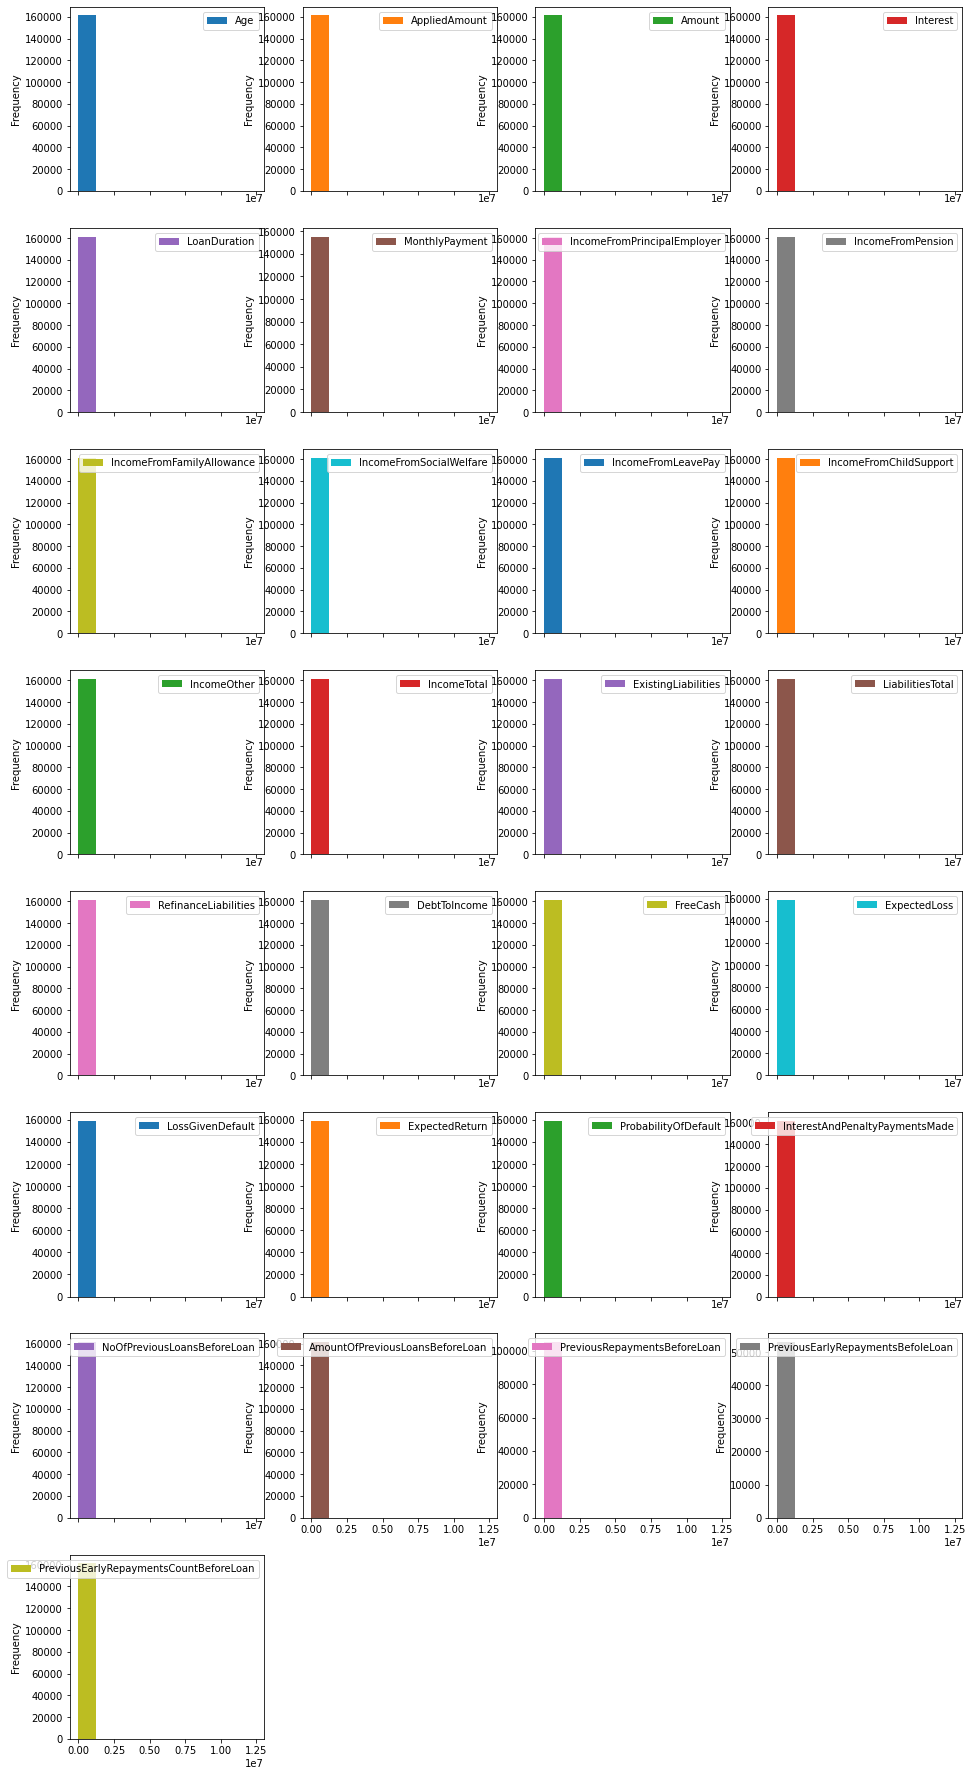

In [26]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

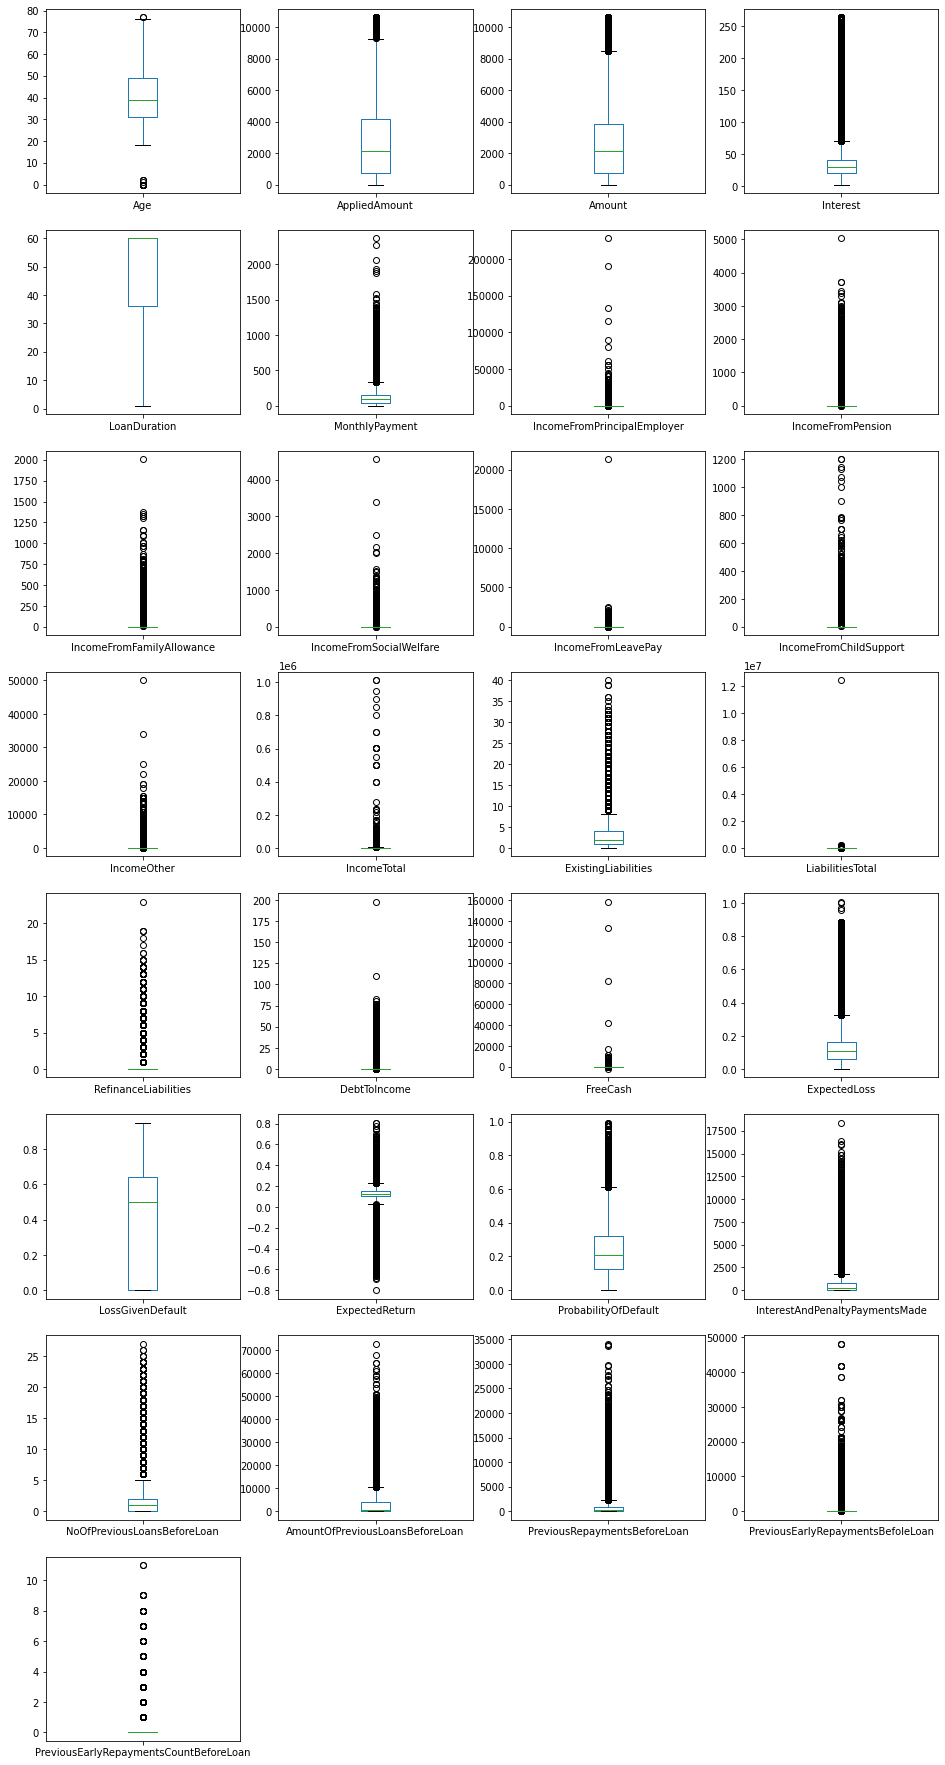

In [27]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

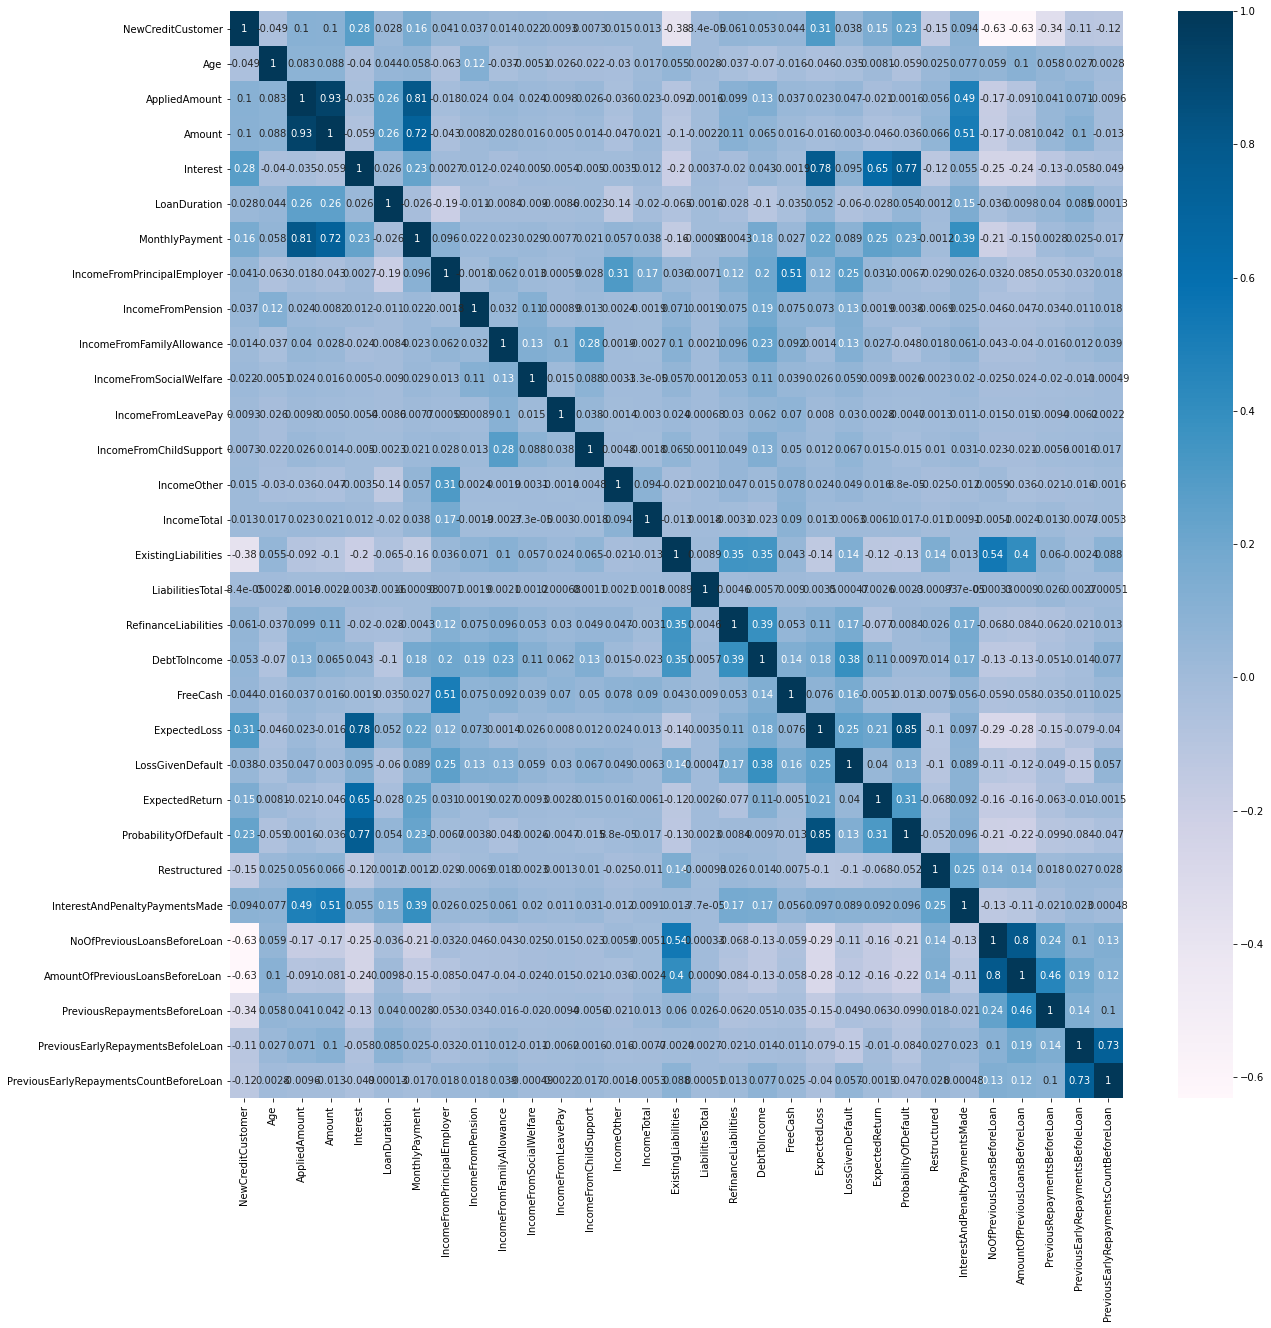

In [28]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [29]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [30]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing

In [31]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = SKL_Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = SKL_Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 29
Number of categorical columns: 9
Total number of columns in the feature dataframe: 38


In [32]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (161311, 38) to array_features_train.shape: (161311, 82)


### 3.b) Training Data Balancing

In [33]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [35]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [36]:
# Finalize the training and validation datasets for the modeling activities
# array_features_train = df_features_train.to_numpy()
array_target_train = df_target_train.ravel()
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (161311, 82) array_target_train.shape: (161311,)


In [37]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [38]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [39]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
start_time_module = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('LGR', LogisticRegression(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('CART', DecisionTreeClassifier(random_state=RNG_SEED)))
train_models.append(('KNN', KNeighborsClassifier(n_jobs=N_JOBS)))
train_models.append(('BGT', BaggingClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('RNF', RandomForestClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('EXT', ExtraTreesClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))

In [40]:
# Generate model in turn
for name, model in train_models:
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	start_time_module = datetime.now()
	kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
	cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - start_time_module), '\n')
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+SCORING_METRIC+') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - start_time_training))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   32.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


LGR: 0.959850 (0.000974)
LogisticRegression(n_jobs=2, random_state=8)
Model training time: 0:00:32.644626 



[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   46.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


CART: 0.898606 (0.002467)
DecisionTreeClassifier(random_state=8)
Model training time: 0:00:46.970273 



[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  9.8min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


KNN: 0.939238 (0.001819)
KNeighborsClassifier(n_jobs=2)
Model training time: 0:09:46.126242 



[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


BGT: 0.973473 (0.001734)
BaggingClassifier(n_jobs=2, random_state=8)
Model training time: 0:02:31.629892 



[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  3.2min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


RNF: 0.979417 (0.000928)
RandomForestClassifier(n_jobs=2, random_state=8)
Model training time: 0:03:09.365826 

EXT: 0.973348 (0.000812)
ExtraTreesClassifier(n_jobs=2, random_state=8)
Model training time: 0:02:38.307121 

Average metrics (roc_auc) from all models: 0.9539885816988307
Total training time for all models: 0:19:25.069141


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  2.6min finished


### 4.b) Spot-checking baseline algorithms

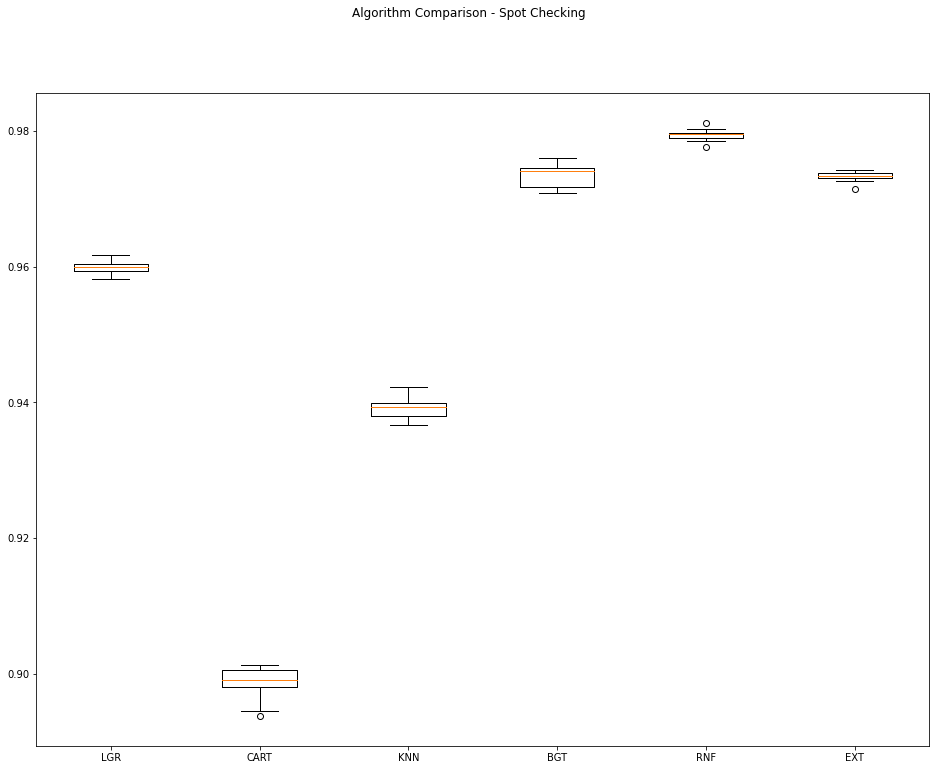

In [41]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [42]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Fine-tune and Improve Models

In [43]:
if NOTIFY_STATUS: status_notify("Task 5 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Algorithm Tuning

In [44]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [45]:
# Tuning algorithm #1 - Extra Trees
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = RandomForestClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)
tune_model_names.append('RNF')
paramGrid1 = dict(n_estimators=np.array([100, 300, 500, 800]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best: 0.980114 using {'n_estimators': 800}
0.979417 (0.000928) with: {'n_estimators': 100}
0.979905 (0.000878) with: {'n_estimators': 300}
0.980042 (0.000838) with: {'n_estimators': 500}
0.980114 (0.000843) with: {'n_estimators': 800}
Model training time: 1:00:53.244565


In [46]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: n_estimators = 800


In [47]:
# Tuning algorithm #2 - Random Forest
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = ExtraTreesClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)
tune_model_names.append('EXT')
paramGrid2 = dict(n_estimators=np.array([100, 300, 500, 800]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best: 0.974214 using {'n_estimators': 800}
0.973348 (0.000812) with: {'n_estimators': 100}
0.973987 (0.000797) with: {'n_estimators': 300}
0.974135 (0.000817) with: {'n_estimators': 500}
0.974214 (0.000824) with: {'n_estimators': 800}
Model training time: 0:51:52.524041


In [48]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 800


### 5.b) Compare Algorithms After Tuning

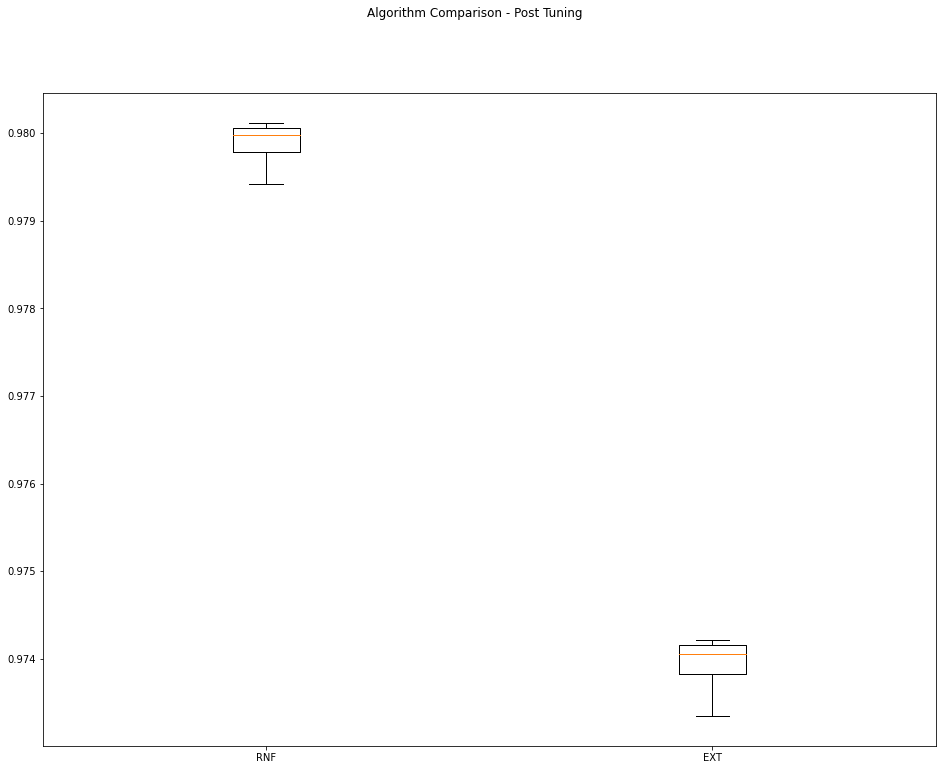

In [49]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [50]:
if NOTIFY_STATUS: status_notify("Task 5 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 6 - Finalize Model and Present Analysis

In [51]:
if NOTIFY_STATUS: status_notify("Task 6 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Train the Final Model

In [52]:
final_model = RandomForestClassifier(n_estimators=best_paramValue1, random_state=RNG_SEED, n_jobs=N_JOBS)
final_model.fit(array_features_train, array_target_train)
print(final_model)

RandomForestClassifier(n_estimators=800, n_jobs=2, random_state=8)


### 6.b) Load Test Dataset and Make Predictions

In [53]:
# We create attribute-only and target-only datasets
df_target_test = df_test['target']
df_features_test = df_test.drop(['target'], axis=1)

print("df_features_test.shape: {} df_target_test.shape: {}".format(df_features_test.shape, df_target_test.shape))

df_features_test.shape: (17924, 38) df_target_test.shape: (17924,)


In [54]:
# Finalize the test dataset for the modeling testing
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (17924, 38) to array_features_test.shape: (17924, 82)


In [55]:
# Finalize the test dataset for the testing activities
array_target_test = df_target_test.ravel()
print("array_features_test.shape: {} array_target_test.shape: {}".format(array_features_test.shape, array_target_test.shape))

array_features_test.shape: (17924, 82) array_target_test.shape: (17924,)


In [56]:
# Make batched predictions
test_predictions = final_model.predict(array_features_test)
print(test_predictions)

[1 1 1 ... 0 0 1]


In [57]:
print('Accuracy Score:', accuracy_score(array_target_test, test_predictions))
print('ROC/AUC Score:', roc_auc_score(array_target_test, test_predictions))
print(confusion_matrix(array_target_test, test_predictions))
print(classification_report(array_target_test, test_predictions))

Accuracy Score: 0.922338763668824
ROC/AUC Score: 0.9162092290993302
[[10204   578]
 [  814  6328]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     10782
           1       0.92      0.89      0.90      7142

    accuracy                           0.92     17924
   macro avg       0.92      0.92      0.92     17924
weighted avg       0.92      0.92      0.92     17924



In [58]:
if NOTIFY_STATUS: status_notify("Task 6 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [59]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 2:19:43.184459
